In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 28 17:54:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   72C    P0              33W /  72W |    365MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Рівняння Бюргерса. Точний розв'язок

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

**Тестова задача.**

Домен $x \in [0,1]$, $\nu=0.005$

Граничні умови

$U(0,t)=U(1,t)=0$


Початкові умови

$\displaystyle u(x,1) =  \frac{x}{1+\sqrt\frac{t}{t_0}\exp(x^2/4\nu )}, \ t\geq1$


[Ali Başhan. Nonlinear dynamics of the Burgers’ equation and numerical experiments Mathematical Sciences. 2021. https://doi.org/10.1007/s40096-021-00410-8
]:

**Точний розв'язок**

$\displaystyle u(x,t) =  \frac{x/t}{1+\sqrt\frac{t}{t_0}\exp(x^2/4\nu t)}, \ t\geq 1$

де $t_0=exp(1/8\nu)$

In [ ]:
import sympy as sp

# Оголошуємо символ x
x, t, t0, nu = sp.symbols('x t t0 nu')

t0 = sp.exp(1/(8*nu))

U = x/t/(1+sp.sqrt(t/t0)*sp.exp(x**2/(4*nu*t)))

print("u(x,t) = ", U)


u(x,t) =  x/(t*(sqrt(t*exp(-1/(8*nu)))*exp(x**2/(4*nu*t)) + 1))


In [ ]:
U

x/(t*(sqrt(t*exp(-1/(8*nu)))*exp(x**2/(4*nu*t)) + 1))

In [ ]:
nu_val = 0.005

In [ ]:
U_subs = U.subs({nu:nu_val})

In [ ]:
f_U = sp.lambdify((x, t), U_subs, "numpy")

x_val = np.linspace(0, 1, num=101)
t_val = np.linspace(1, 4, num=301)

X_val, T_val = np.meshgrid(x_val, t_val)

U_val = f_U(X_val, T_val)

U_val = U_val.T




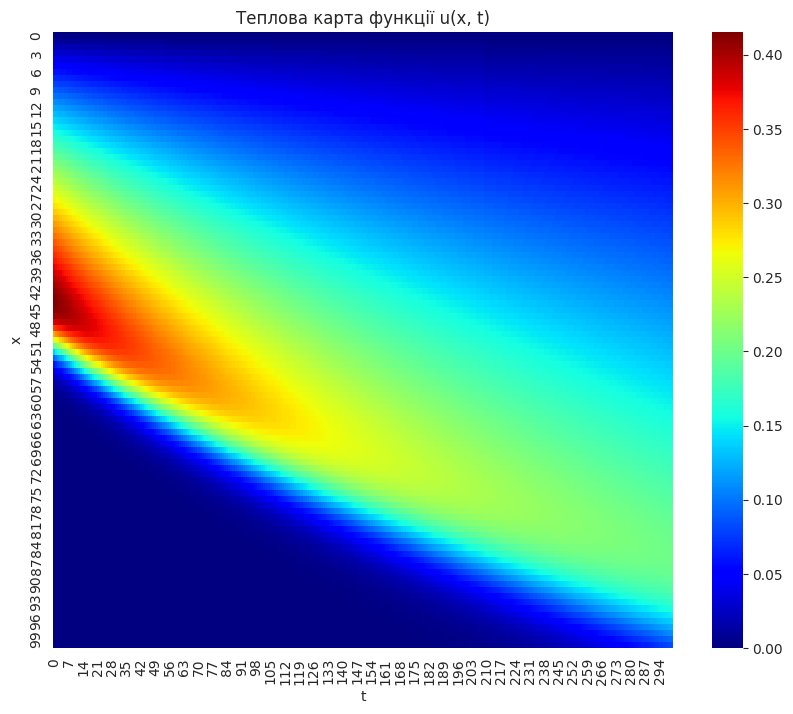

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(U_val, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()


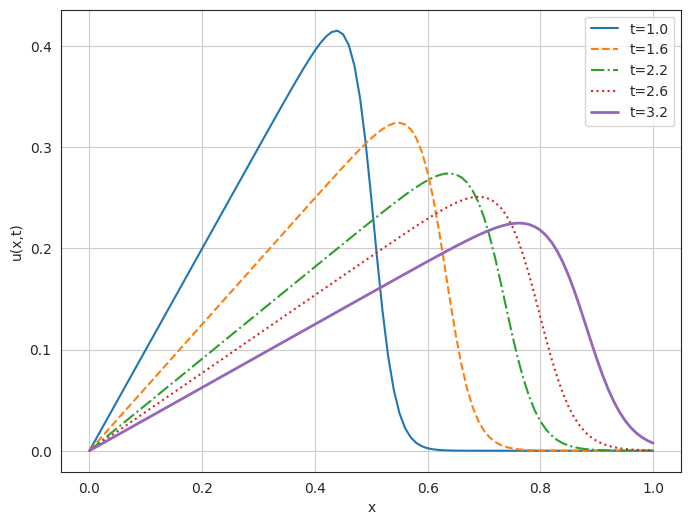

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x_val, U_val[:,0], label='t=1.0', linestyle='-')
plt.plot(x_val, U_val[:,60], label='t=1.6', linestyle='--')
plt.plot(x_val, U_val[:,120], label='t=2.2', linestyle='-.')
plt.plot(x_val, U_val[:,160], label='t=2.6', linestyle=':')
plt.plot(x_val, U_val[:,220], label='t=3.2', linestyle='-', linewidth=2)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


#Розв'язок засобами PINN

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32,32),
            # nn.Tanh(),
            # nn.Linear(20,20),

            nn.Tanh(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [ ]:
# h = 0.01
# k = 0.01
# nu = 0.5

# x = torch.arange(0,8+h, h)
# t = torch.arange(0,5+k, k)

# X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
# bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T

# # bc2[:,1]+10e-5
# # X[:,1]
# # bc2.size()
# # X.size()
# y_bc2 = (bc2[:,0]/(bc2[:,1]+10e-6))*1/(1+torch.sqrt((bc2[:,1]+10e-6)*nu/0.125)*torch.exp(bc2[:,0]**2/4*nu*(bc2[:,1]+10e-6)))
# y_bc2

torch.pi

3.141592653589793

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        self.x_max = 1
        self.t_max = 4

        # comp. domain
        self.h = 0.01
        self.k = 0.01
        self.nu = 0.005
        self.epoch = 4000

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)


        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        # ic2  = torch.stack(torch.meshgrid(x,t[-1])).reshape(2,-1).T
        # print('bc1, ', bc1.shape)
        # print('bc2, ', bc2.shape)
        # print('ic, ', ic.shape)
        # breakpoint()

        self.X_train = torch.cat([bc1, bc2, ic])

        # print('self.X_train ', self.X_train.shape)
        # breakpoint()

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        t0 = torch.exp(torch.tensor([1/(8*self.nu)]))

        y_ic  = ic[:,0] / (1 + torch.sqrt(1/t0)*torch.exp((ic[:,0]**2)/(4*self.nu)))

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])


        self.y_train = self.y_train.unsqueeze(1)



        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 6000,
            max_eval = 6000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - self.nu * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            print(loss_pde.item())
            print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
net = Net()
net.train()

100 0.004107972607016563
0.00023729064560029656
0.003870682092383504
200 0.0036741134244948626
0.0002528254990465939
0.0034212879836559296
300 0.002787312027066946
0.00019836488354485482
0.002588947070762515
400 0.0020829453133046627
0.00025916675804182887
0.001823778497055173
500 0.0016855011926963925
0.0003001923905685544
0.0013853088021278381
600 0.0014258639421314
0.00032285205088555813
0.001103011891245842
700 0.0011974270455539227
0.0003214162716176361
0.000876010803040117
800 0.0010296814143657684
0.0003267901483923197
0.0007028912077657878
900 0.0009365146979689598
0.0003316272923257202
0.0006048874347470701
1000 0.0008540133712813258
0.0003128796524833888
0.0005411337479017675
1100 0.0007934452150948346
0.00029435771284624934
0.0004990875022485852
1200 0.0007323927711695433
0.0002715490118134767
0.00046084378845989704
1300 0.0006666126428171992
0.00024748381110839546
0.0004191288317088038
1400 0.0005921949632465839
0.00022053896100260317
0.0003716559731401503
1500 0.0005134502

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [ ]:
X

tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.0000, 3.9800],
        [1.0000, 3.9900],
        [1.0000, 4.0000]], device='cuda:0')

In [ ]:
X.shape

torch.Size([30401, 2])

In [ ]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [ ]:
y_pred.shape

(101, 301)

In [ ]:
y_pred

array([[ 1.1652708e-04,  3.2007694e-05, -4.6789646e-05, ...,
        -8.5771084e-05, -1.0186434e-04, -1.1807680e-04],
       [ 1.0271430e-02,  1.0084510e-02,  9.9055767e-03, ...,
         2.3275018e-03,  2.3078918e-03,  2.2878051e-03],
       [ 2.0419836e-02,  2.0132244e-02,  1.9853711e-02, ...,
         4.7455430e-03,  4.7217011e-03,  4.6975017e-03],
       ...,
       [-1.7014146e-03, -1.7296672e-03, -1.7480254e-03, ...,
         5.8473587e-02,  5.9412301e-02,  6.0342908e-02],
       [-1.4088750e-03, -1.4515519e-03, -1.4819503e-03, ...,
         3.2015860e-02,  3.2699943e-02,  3.3386528e-02],
       [-1.0331273e-03, -1.0930896e-03, -1.1389852e-03, ...,
         5.1156282e-03,  5.4305196e-03,  5.7541132e-03]], dtype=float32)

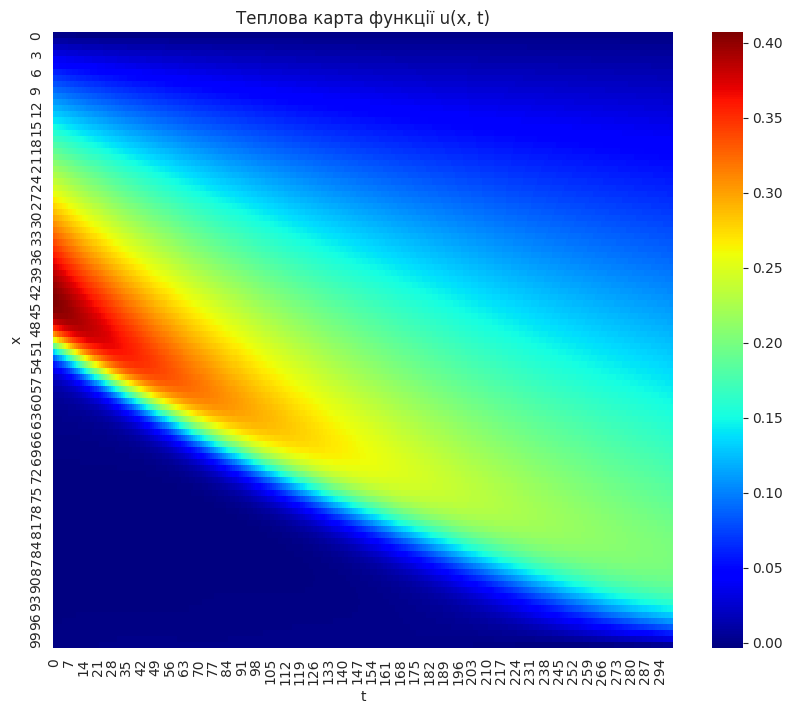

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()



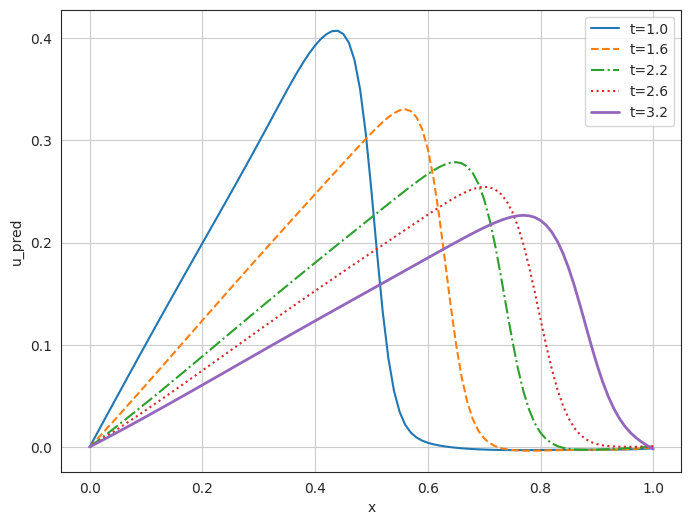

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x, y_pred[:,0], label='t=1.0', linestyle='-')
plt.plot(x, y_pred[:,60], label='t=1.6', linestyle='--')
plt.plot(x, y_pred[:,120], label='t=2.2', linestyle='-.')
plt.plot(x, y_pred[:,160], label='t=2.6', linestyle=':')
plt.plot(x, y_pred[:,220], label='t=3.2', linestyle='-', linewidth=2)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u_pred')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


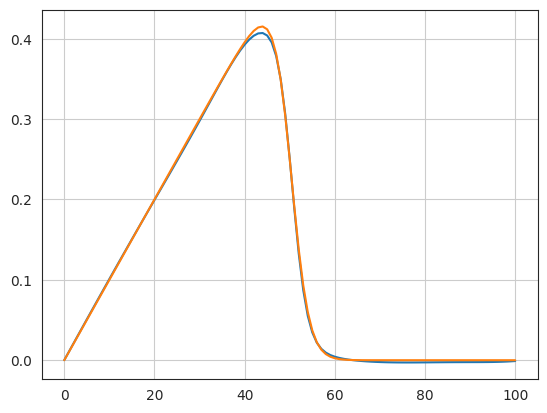

In [ ]:
plt.plot(y_pred[:,0])
plt.plot(U_val[:,0])

plt.grid(True)
plt.show()

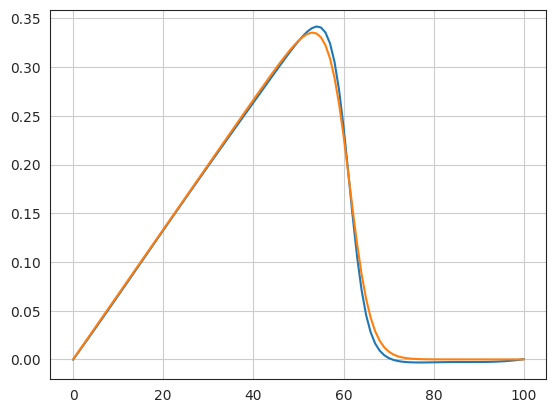

In [ ]:
plt.plot(y_pred[:,50])
plt.plot(U_val[:,50])

plt.grid(True)
plt.show()

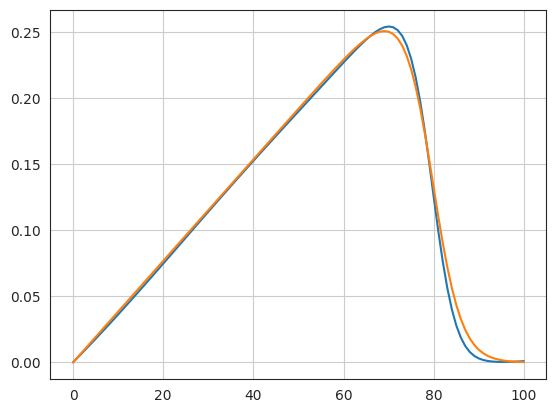

In [ ]:
plt.plot(y_pred[:,160])
plt.plot(U_val[:,160])

plt.grid(True)
plt.show()

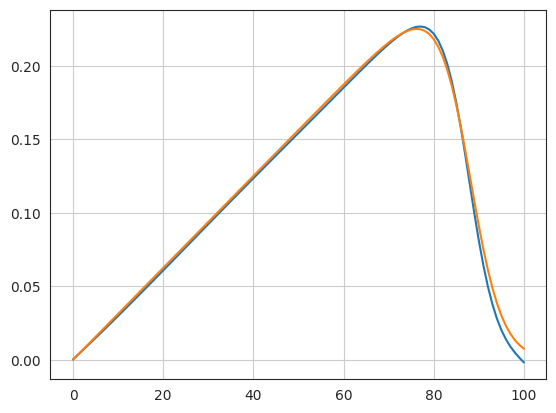

In [ ]:
plt.plot(y_pred[:,220])
plt.plot(U_val[:,220])

plt.grid(True)
plt.show()

In [ ]:
U_val.shape

(101, 301)

In [ ]:
y_pred.shape

(101, 301)

In [ ]:
from sklearn.metrics import r2_score

r2_score(U_val, y_pred)

0.9942856111213145

#Обернена задача

In [ ]:
class Net_inv:
    def __init__(self, uf):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.viscosity_coeff = 0.005
        lambda_value = 2.0
        print("the real value =",self.viscosity_coeff, "     Our I-PINNs value=", lambda_value)
        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).float().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)

        self.x_max = 1
        self.t_max = 4
        # comp. domain
        self.h = 0.01
        self.k = 0.01

        self.epoch = 4000

        self.lambda_hist = []
        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)




        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()

        print(self.X)

        # train data

        self.X_train = self.X

        self.y_train = torch.tensor(uf)

        self.y_train = self.y_train.view(-1)
        self.y_train = self.y_train.unsqueeze(1)

        print(self.y_train)

        # breakpoint()

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 6000,
            max_eval = 6000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        lambda_pde  = self.lambda_value

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - lambda_pde * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        self.lambda_hist.append(self.lambda_value.item())
        if self.iter % 100 == 0:
            print("iteration number =",self.iter, " loss value =", loss.item(), "real mu=",self.viscosity_coeff,"IPINN lambda=", self.lambda_value.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
net_inv = Net_inv(y_pred)
net_inv.train()
net_inv.model.eval()

the real value = 0.005      Our I-PINNs value= 2.0
tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.0000, 3.9800],
        [1.0000, 3.9900],
        [1.0000, 4.0000]])
tensor([[ 1.1653e-04],
        [ 3.2008e-05],
        [-4.6790e-05],
        ...,
        [ 5.1156e-03],
        [ 5.4305e-03],
        [ 5.7541e-03]])
iteration number = 100  loss value = 0.008840365335345268 real mu= 0.005 IPINN lambda= 1.9631847143173218
iteration number = 200  loss value = 0.008155916817486286 real mu= 0.005 IPINN lambda= 1.9156006574630737
iteration number = 300  loss value = 0.007646780926734209 real mu= 0.005 IPINN lambda= 1.8633685111999512
iteration number = 400  loss value = 0.0073097338899970055 real mu= 0.005 IPINN lambda= 1.82475745677948
iteration number = 500  loss value = 0.007218895945698023 real mu= 0.005 IPINN lambda= 1.8091951608657837
iteration number = 600  loss value = 0.007199457380920649 real mu= 0.005 IPINN lambda= 1.777320027

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

model = net_inv.model
model.eval()
with torch.no_grad():
    y_pred_inv = model(X)
    y_pred_inv = y_pred_inv.reshape(len(x),len(t)).cpu().numpy()

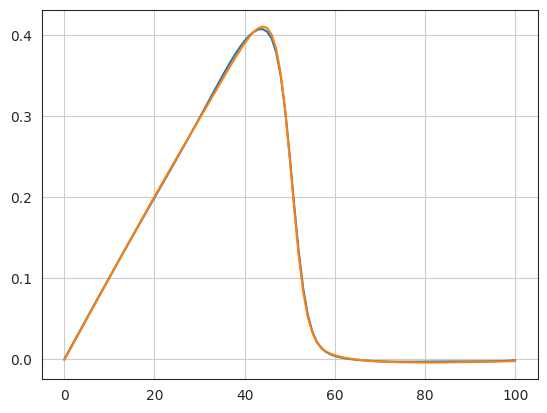

In [ ]:
plt.plot(y_pred[:,0])
plt.plot(y_pred_inv[:,0])

plt.grid(True)
plt.show()

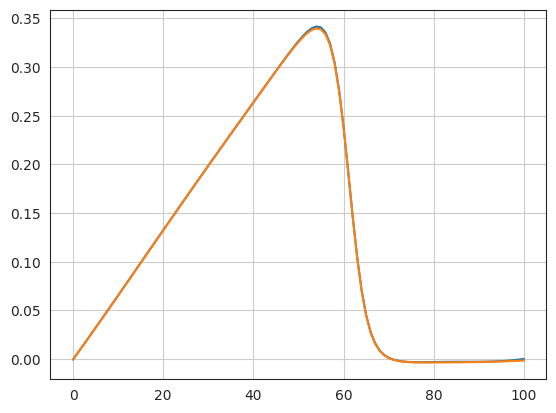

In [ ]:
plt.plot(y_pred[:,50])
plt.plot(y_pred_inv[:,50])

plt.grid(True)
plt.show()

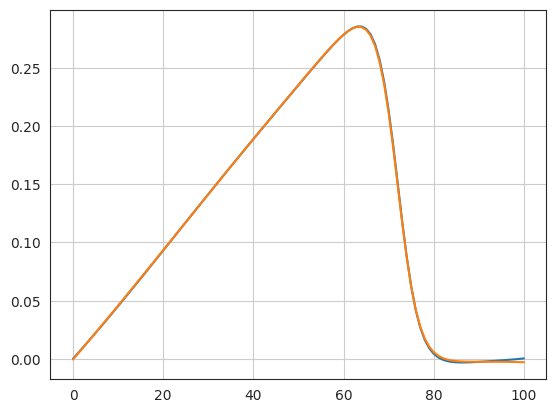

In [ ]:
plt.plot(y_pred[:,110])
plt.plot(y_pred_inv[:,110])

plt.grid(True)
plt.show()

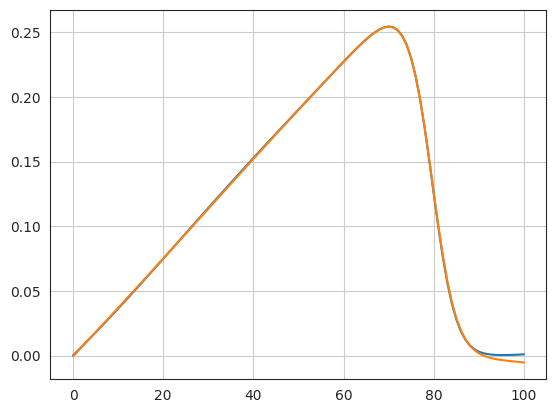

In [ ]:
plt.plot(y_pred[:,160])
plt.plot(y_pred_inv[:,160])

plt.grid(True)
plt.show()

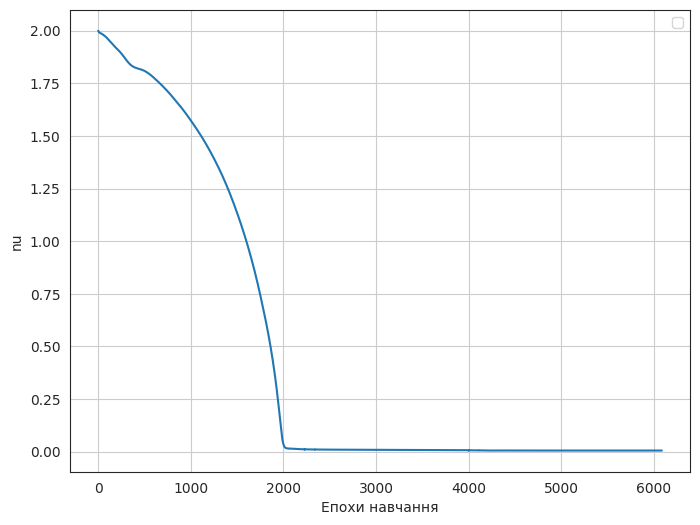

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('nu')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


In [ ]:
(net.nu - net_inv.lambda_hist[-1])/net.nu*100

0.11760033667087763